# 第五章 信号的时间尺度

## 5.1 导言

信息具有时间维度，它们到达的频率不同，其价值体现的时期有长有短。多数信息的到达频率是固定的，而我们更感兴趣的是其保质期，即信息的时间尺度。
这是一个将在三四天内消失的快速信号，还是一个在随后一年中具有持续价值的缓慢信号？最新的信息并不一定是最好的，在某些情况下，新信息与旧信息的混合比最新的信息更有价值。

在前面几章中，我们了解了如何从原始信号中，得出精炼预测。在本章中，我们要先从时间维度上处理原始信号，然后再用同样的方法得出精炼预测。虽然有很大部分程序与前面几章完成的工作类似，但是，我们的程序也将越来越精练。我们将和读者共同体验不断优化程序的过程。

## 5.2 基础知识准备

对策略的信息时间尺度或信息保质期的一个自然定义是IC的衰减速率，即衰减系数。它衡量了，如果我们在获得信号后，因为种种原因，比如拖延症，使得我们下单晚了一天，那么我们将付出怎样的代价。一般来说，延迟下单会导致我们的业绩下降，即IC的下降。那么IC衰减到一半所需要延迟的时间，即半衰期，就是一个很好的度量。谈到半衰期，如果它能比较好的度量IC的衰减，那么，这意味着IC的衰减是类似于指数衰减的。这是一个合理的假设，这等价于，在每个时期中，IC衰减固定的比例。

而且，经过数学推导，我们发现，在时间维度上重组信号，对于半衰期没有任何影响。这是一个非常好的性质，可以让我们做更多的事情。我们可以推导出，如何在时间维度上重组信号是最优的：
$$s^\star(0) = s(0) - \rho \cdot s(-\Delta t) + \delta \cdot s^\star(-\Delta t)$$
其中，$s(0)$表示当前到达的新信号，$s^\star(0)$表示$s(0)$在时间维度重组后的信号，$s(-\Delta t)$表示上一期到达的信号，$s\star(-\Delta t)$表示$s(-\Delta t)$在时间维度重组后的信，$\delta$表示衰减系数，$\rho$表示信号的自相关系数。

详细的数学细节我们并不推导，我们只需要知道上式包含两部分，一部分是新信号所带来的新信息，另一部分是旧信号所遗留的信息。这样就不难理解上式的意义了。本章的实验，将围绕上式来进行。

## 5.3 操作总览

本实验由以下几个步骤组成：
1. 步骤一：分别计算前述信号的自相关系数
2. 步骤二：分别计算前述信号的衰减系数
3. 步骤三：分别在时间尺度上混合前述信号
4. 步骤四：重新计算混合信号的IC和$\alpha$

## 5.4 操作流程

### 5.4.0 准备工作

和前面的章节一样，本章的代码也是可以独立运行的，所以我们需要先做一些准备工作。

首先，我们导入包：

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats

import tushare as ts

然后我们获取股票数据和上证50指数数据：

In [2]:
stock_list = ts.get_sz50s().code
stock_data = {}
for stock in stock_list:
    stock_data[stock] = ts.get_k_data(stock, start='2017-01-01', end='2017-12-31')
    
index_name = '000016'
index_data = ts.get_k_data(index_name, index=True, start='2017-01-01', end='2017-12-31')

C:\Users\huang\Anaconda3\lib\site-packages\tushare\stock\classifying.py:266: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  ct.PAGES['sz50b']), parse_cols=[0, 4, 5])


整理数据：

In [3]:
#整理股票数据
stock_0 = pd.DataFrame(index=index_data.date)
stock_na = pd.DataFrame(index=index_data.date)
stock_open = stock_0.copy()
stock_high = stock_0.copy()
stock_low = stock_0.copy()
stock_close = stock_0.copy()

for stock in stock_list:
    stock_0 = stock_0.join(pd.DataFrame(0.0, index=stock_data[stock].date, columns=[stock]))
    stock_na = stock_na.join(pd.DataFrame(stock_data[stock].open.isna().values, index=stock_data[stock].date, columns=[stock]))
    stock_open = stock_open.join(pd.DataFrame(stock_data[stock].open.values, index=stock_data[stock].date, columns=[stock]))
    stock_high = stock_high.join(pd.DataFrame(stock_data[stock].high.values, index=stock_data[stock].date, columns=[stock]))
    stock_low = stock_low.join(pd.DataFrame(stock_data[stock].low.values, index=stock_data[stock].date, columns=[stock]))
    stock_close = stock_close.join(pd.DataFrame(stock_data[stock].close.values, index=stock_data[stock].date, columns=[stock]))
    
stock_rtn = stock_0.copy()
for stock in stock_list:
    stock_rtn[stock] = stock_close[stock] / stock_close[stock].shift() - 1
stock_rtn = stock_rtn.fillna(0)

#整理指数数据
index_0 = pd.DataFrame(0.0, index=index_data.date, columns=[index_name])
index_open = pd.DataFrame(index_data.open.values, index=index_data.date, columns=[index_name])
index_high = pd.DataFrame(index_data.high.values, index=index_data.date, columns=[index_name])
index_low = pd.DataFrame(index_data.low.values, index=index_data.date, columns=[index_name])
index_close = pd.DataFrame(index_data.close.values, index=index_data.date, columns=[index_name])

index_rtn = index_close / index_close.shift() - 1
index_rtn = index_rtn.fillna(0)

#计算主动收益率
stock_active_rtn = stock_rtn - np.repeat(index_rtn.values, stock_rtn.columns.size, axis=1)
stock_active_rtn_std = stock_active_rtn.std()

计算“红三兵”：

In [4]:
def cal_rtn_predictor_r3s():
    #初始化返回值
    res = stock_0.copy().fillna(0)
    #计算每只股票的预测值
    for stock in stock_list:
        #计算每日的预测值
        for i in range(2, len(stock_0)):
            idx = list(range(i - 2, i + 1))      
            if stock_na[stock][idx].sum():
                #剔除近三日有停牌的股票
                res[stock][i] = 0.0
            else:
                o = stock_open[stock][idx].copy()
                c = stock_close[stock][idx].copy()
                h = stock_high[stock][idx].copy()
                l = stock_low[stock][idx].copy()
                r = stock_rtn[stock][idx].copy()
                os = o.shift(-1)
                #计算
                d = (r > 0).sum()
                #近三日中有两日以上上涨
                if d > 0:
                    #每日开盘是否在上日K线实体之内
                    in_entity = (os > o).sum() + (os < c).sum()
                    #计算惩罚函数
                    loss = (c / h - 1).std() + r.std() + (3 - d) / 100 + (4 - in_entity) / 100
                    if loss < 0.05:
                        #看涨，预测收益率
                        res[stock][i] = 0.05 - loss
                #近三日中有两日以上没有上涨
                elif d < 0:
                    #每日开盘是否在上日K线实体之内
                    in_entity = (os < o).sum() + (os > c).sum()
                    #计算惩罚函数
                    loss = (c / l - 1).std() + r.std() + (3 - d) / 100 + (4 - in_entity) / 100
                    if loss < 0.05:
                        #看跌，预测收益率
                        res[stock][i] = -0.05 + loss
    return res

rtn_predictor_r3s = cal_rtn_predictor_r3s()

计算动量信号：

In [5]:
def ma_calculator(data, n):
    res = data.copy()
    for i in range(1, n):
        res += data.shift(i)
    return res / n

def cal_rtn_predictor_ma():
    stock_ma_excess = ma_calculator(stock_close, 3) / ma_calculator(stock_close, 13) - 1
    stock_ma_excess_quantile = stock_ma_excess.fillna(0.0).rank(axis=1) / 51.0
    return stock_ma_excess_quantile.apply(sp.stats.norm(0,1).ppf)

rtn_predictor_ma = cal_rtn_predictor_ma()

以上，我们完成了本章的准备工作，其主要是整理前几章的相关内容。

### 5.4.1 步骤一：分别计算前述信号的自相关系数

计算自相关系数，属于时间序列范畴，我们引入包StatsModels，其中关于时间序列的模块tsa则是本节所需要的。

我们首先介绍一下StatsModels包。
它是一个包含很多统计模型的Python库，能完成很多统计测试、数据探索以及可视化。它包含的模型主要有：
1. 线性模型
2. 广义线性模型
3. 鲁棒线性模型
4. 线性混合效应模型
5. 方差分析模型
6. 时间序列模型
7. 状态空间模型
8. 广义矩估计方法

和上一章提到的SciPy一样，StatsModels包含太多模型和方法，我们无法穷尽它的细节。更推荐的做法是：每当遇到统计模型的问题时，就去StatsModels对应模块的手册中检索，看看它是否提供了解决问题的工具。如果有，在专项的仔细学习这个工具，并使用之。它的介绍在这里：

http://www.statsmodels.org/

接下来，我们导入包：

In [15]:
from statsmodels.tsa.stattools import acf

我们以股票600000为例，计算一下动量信号的自相关系数：

[ 1.          0.92736757  0.81341772  0.67877455  0.55006127  0.42918985
  0.323986    0.22033431  0.12189459  0.03234976 -0.04277666 -0.10926846
 -0.14415887 -0.15286969 -0.16363959 -0.17367554 -0.18411708 -0.18609312
 -0.18888445 -0.19628246 -0.21123687 -0.2383439  -0.26773853 -0.29545737
 -0.3079923  -0.30055539 -0.2827889  -0.25747674 -0.22684602 -0.18562951
 -0.12336758 -0.04807819  0.01644718  0.06944545  0.11033008  0.13169745
  0.1380352   0.14317861  0.1545149   0.17108337  0.18286562]


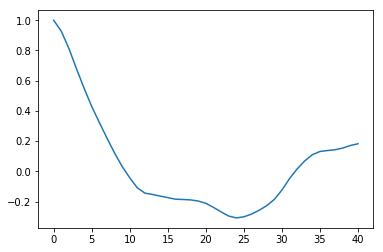

In [18]:
acf_600000 = acf(rtn_predictor_ma['600000'])
print(acf_600000)
plt.plot(acf_600000)
plt.show()

可以看出，其自相关性还是比较明显的。一阶自相关系数为0.93。
然后，我们可以计算在不同股票上，动量信号的一阶自相关系数：

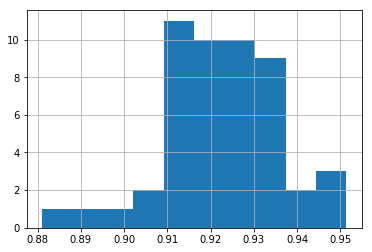

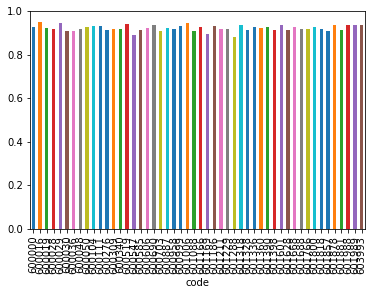

In [37]:
acf_ma_all = pd.Series(index=stock_list)
for stock in stock_list:
    acf_ma_all[stock] = acf(rtn_predictor_ma[stock])[1]
acf_ma_all.hist()
plt.show()
acf_ma_all.plot(kind='bar')
plt.show()

可以看到，不同股票上，动量信号的一阶自相关系数非常接近，我们完全可以假设它们相同。
事实上，我们通常也确实是这样假设的：

In [31]:
acf_ma = acf_ma_all.mean()
print(acf_ma)

0.9219703409874813


同理，我们可以计算“红三兵”的自相关系数：

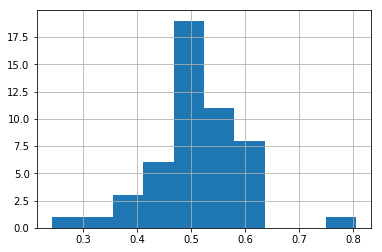

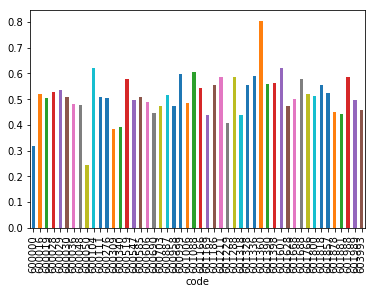

0.510420515853176


In [38]:
acf_r3s_all = pd.Series(index=stock_list)
for stock in stock_list:
    acf_r3s_all[stock] = acf(rtn_predictor_r3s[stock])[1]
acf_r3s_all.hist()
plt.show()
acf_r3s_all.plot(kind='bar')
plt.show()
acf_r3s = acf_r3s_all.mean()
print(acf_r3s)

### 5.4.2 步骤二：分别计算前述信号的衰减系数

我们计算IC = IC(1)时，是计算t时刻某信号的预测与t+1时刻标的的收益率的相关系数。
而我们可以类似的计算IC(2)，即t时刻该信号的预测与t+2时刻标的的收益率的相关系数。
而IC(2) / IC(1)即可用于估计衰减系数。那么，我们先来计算两个信号的IC：

In [61]:
ic_r3s = np.corrcoef(stock_active_rtn.shift(-1).fillna(0.0).values.reshape(stock_active_rtn.size), rtn_predictor_r3s.values.reshape(rtn_predictor_r3s.size))[0,1]
ic_ma = np.corrcoef(stock_active_rtn.shift(-1).fillna(0.0).values.reshape(stock_active_rtn.size), rtn_predictor_ma.values.reshape(rtn_predictor_ma.size))[0,1]
print(ic_r3s, ic_ma)

0.021196474841295682 0.018161850741592208


我们可以按公式计算两个信号各自的IC(2)：

In [62]:
ic_r3s_2 = np.corrcoef(stock_active_rtn.shift(-2).fillna(0.0).values.reshape(stock_active_rtn.size), rtn_predictor_r3s.values.reshape(rtn_predictor_r3s.size))[0,1]
ic_ma_2 = np.corrcoef(stock_active_rtn.shift(-2).fillna(0.0).values.reshape(stock_active_rtn.size), rtn_predictor_ma.values.reshape(rtn_predictor_ma.size))[0,1]
print(ic_r3s_2, ic_ma_2)

0.022852370728970273 0.014806687096277636


我们注意到，对于“红三兵”，IC(2)竟然比IC(1)大，这看起来不符合我们的假设，但也很可能是误差导致的。所以，我们需要更精确的计算。
一个显然的方法是：再计算IC(3)……IC(60)，然后分别计算IC(3)/IC(2)……IC(60)/IC(59)，最后求均值。为了方便起见，我们写两个函数来处理：

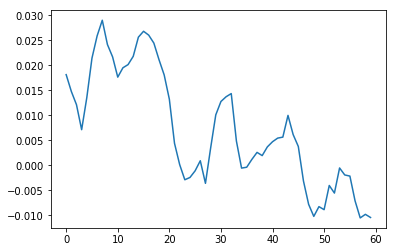

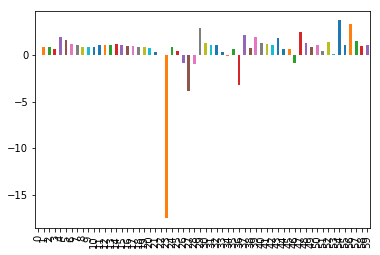

0.5503052710363614

In [71]:
def cal_ic(rtn_predictor, n):
    res = pd.Series((n), dtype=float)
    for i in range(n):
        res[i] = np.corrcoef(stock_active_rtn.shift(-i - 1).fillna(0.0).values.reshape(stock_active_rtn.size), rtn_predictor.values.reshape(rtn_predictor.size))[0,1]
    res.plot()
    plt.show()
    return res

def cal_ac(rtn_predictor):
    ic = cal_ic(rtn_predictor, 60)
    ac = ic / ic.shift()
    ac.plot(kind='bar')
    plt.show()
    return ac.mean()

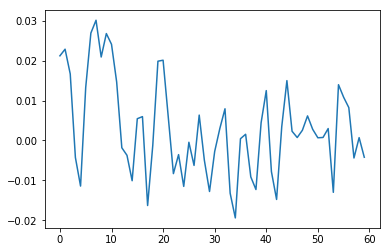

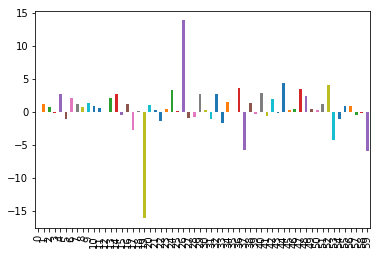

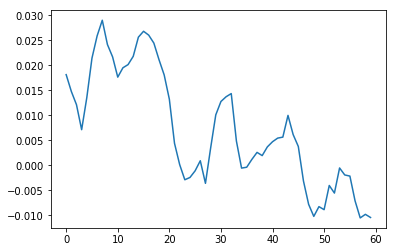

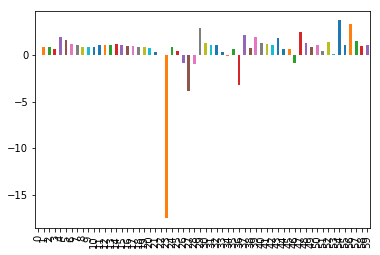

衰减系数 ac =  0.4107782471107033 0.5503052710363614


In [73]:
ac_r3s = cal_ac(rtn_predictor_r3s)
ac_ma = cal_ac(rtn_predictor_ma)
print("衰减系数 ac = ", ac_r3s, ac_ma)

我们可以看到，衰减系数的估计，并不很准确。这与我们用的方法较为简单有关。
在这个问题上，尚有很多改进方案，读者也可以好好想一想。

一个可能的改进方案是：既然我们假设IC按指数衰减，那么，我们可以求log(IC(n))，这样，可以把指数衰减变为线性衰减。
然后，我们可以通过回归的方式，得到衰减系数。

另外，充足的数据量，也是精确计算衰减系数的保证。而且，我们现在是在日尺度上计算衰减系数，如果我们按月尺度计算，然后再折算到日上面，应该会有更好的结果。我们把这里的改进方案作为我们的课堂联系，由读者来完成。

In [ ]:
#改进衰减系数的计算方法。

### 5.4.3 步骤三：分别在时间尺度上混合前述信号

根据公式
$$s^\star(0) = s(0) - \rho \cdot s(-\Delta t) + \delta \cdot s^\star(-\Delta t)$$
我们可以在时间尺度上混合前述信号：

In [77]:
def cal_mix_predictor(rtn_predictor, rho, delta):
    res = rtn_predictor.copy()
    for i in range(1, len(res)):
        res.iloc[i, :] = rtn_predictor.iloc[i, :] - rho * rtn_predictor.iloc[i - 1, :] + delta * res.iloc[i - 1, :]
    return res

rtn_mix_predictor_r3s = cal_mix_predictor(rtn_predictor_r3s, acf_r3s, ac_r3s)
rtn_mix_predictor_ma = cal_mix_predictor(rtn_predictor_ma, acf_ma, ac_ma)

print("红三兵混合信号：")
print(rtn_mix_predictor_r3s.tail())
print("动量混合信号：")
print(rtn_mix_predictor_ma.tail())

红三兵混合信号：
              600000    600016        600019    600028    600029    600030  \
date                                                                         
2017-12-25 -0.000115 -0.001726 -7.706033e-10  0.017761  0.007060  0.002299   
2017-12-26  0.001288 -0.000709  5.792958e-03  0.018871 -0.001145 -0.000242   
2017-12-27  0.003481  0.004559  1.360072e-02  0.007905 -0.000470 -0.000099   
2017-12-28  0.000221  0.003861  1.257388e-02  0.017951 -0.000193  0.002616   
2017-12-29  0.000756 -0.000692  2.333428e-03  0.000731  0.005468 -0.000281   

              600036        600048        600050    600104    ...     \
date                                                          ...      
2017-12-25  0.002404 -4.774300e-09 -5.485561e-07  0.019438    ...      
2017-12-26 -0.001471 -1.961179e-09 -2.253349e-07 -0.004074    ...      
2017-12-27 -0.000604 -8.056095e-10 -9.256268e-08 -0.001674    ...      
2017-12-28 -0.000248  1.598982e-03 -3.802274e-08 -0.000688    ...      
2017-12-29 -

### 5.4.4 步骤四：重新计算混合信号的IC和$\alpha$

信号在时间尺度上混合后，再计算IC时，会有变化，理论上应该更大一点。我们通过函数来计算一下：

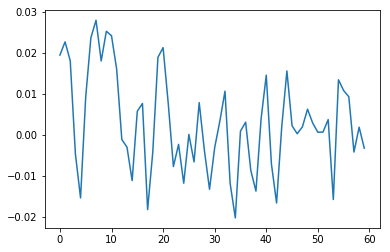

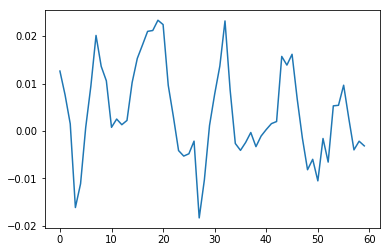

0.019421165373017833 0.012625107879146887


In [78]:
ic_mix_r3s = cal_ic(rtn_mix_predictor_r3s, 60)[0]
ic_mix_ma = cal_ic(rtn_mix_predictor_ma, 60)[0]
print(ic_mix_r3s, ic_mix_ma)

可以看出IC的计算，也不太稳定，这也是跟算法有关，读者可以试着改进其算法。

下面我们用混合后的信号来计算精炼预测，我们先从“红三兵”开始，我们使用基于时间序列数据的方法来计算：

In [79]:
def cal_ts_alpha(rtn_predictor, ic):
    z = rtn_predictor / rtn_predictor.values.std()
    return np.repeat(np.array(stock_active_rtn_std).reshape(1, stock_rtn.columns.size), len(stock_rtn), axis=0) * ic * z

alpha_mix_r3s = cal_ts_alpha(rtn_mix_predictor_r3s, ic_mix_r3s)
print(alpha_mix_r3s.tail())

              600000    600016        600019    600028    600029    600030  \
date                                                                         
2017-12-25 -0.000002 -0.000028 -3.125170e-11  0.000394  0.000270  0.000054   
2017-12-26  0.000024 -0.000011  2.349325e-04  0.000419 -0.000044 -0.000006   
2017-12-27  0.000066  0.000073  5.515750e-04  0.000175 -0.000018 -0.000002   
2017-12-28  0.000004  0.000062  5.099318e-04  0.000398 -0.000007  0.000061   
2017-12-29  0.000014 -0.000011  9.463182e-05  0.000016  0.000209 -0.000007   

              600036        600048        600050    600104      ...       \
date                                                            ...        
2017-12-25  0.000065 -1.843988e-10 -2.416703e-08  0.000573      ...        
2017-12-26 -0.000040 -7.574700e-11 -9.927288e-09 -0.000120      ...        
2017-12-27 -0.000016 -3.111522e-11 -4.077914e-09 -0.000049      ...        
2017-12-28 -0.000007  6.175782e-05 -1.675118e-09 -0.000020      ...      

接下来，我们计算动量信号，我们需要使用基于截面数据的算法来计算：

In [93]:
def cal_cs_alpha(rtn_predictor, ic):
    std_cs = rtn_predictor.std(axis = 1)
    z = rtn_predictor.fillna(0.0) / np.repeat(std_cs.values.reshape(std_cs.size, 1), stock_list.size, axis=1)
    z_omega = z / np.repeat(stock_active_rtn_std.values.reshape(1, stock_active_rtn_std.size), len(stock_active_rtn), axis=0)
    c = z_omega.fillna(0.0).values.std()
    return ic / c * z

alpha_mix_ma = cal_cs_alpha(rtn_mix_predictor_ma, ic_mix_ma)
print(alpha_mix_ma.tail())

              600000    600016    600019    600028    600029    600030  \
date                                                                     
2017-12-25 -0.000177 -0.000115  0.000125  0.000050  0.000394  0.000124   
2017-12-26 -0.000221 -0.000087 -0.000082  0.000126  0.000280  0.000126   
2017-12-27 -0.000056  0.000027 -0.000104  0.000202  0.000183  0.000073   
2017-12-28  0.000013  0.000002  0.000172  0.000182  0.000132  0.000145   
2017-12-29  0.000089  0.000008  0.000210  0.000109 -0.000077  0.000022   

              600036    600048    600050    600104    ...       601688  \
date                                                  ...                
2017-12-25  0.000006  0.000671 -0.000122  0.000010    ...    -0.000075   
2017-12-26  0.000029  0.000650 -0.000113  0.000020    ...    -0.000096   
2017-12-27  0.000060  0.000366 -0.000091 -0.000095    ...    -0.000092   
2017-12-28 -0.000120  0.000226 -0.000076 -0.000107    ...    -0.000084   
2017-12-29 -0.000242  0.000193 -0.000

## 5.5 延伸阅读——另类信号

我们在精炼信号的过程中，用到了比较复杂的方法。尽管复杂，但终归是线性的方法。
然而，我们其实也知道，线性的方法在刻画现实上，往往是很无力的。
那么，非线性的方法能否应用进来呢？

事实上，确实有很多人尝试了很多非线性的方法，也找到了一些不错的方法，我们将简介于此。
然而，我们要注意的是，在真正的基金中，非线性方法的实践是非常罕见的。
因为，对大部分基金经理而言，委托代理风险比市场风险更重要——
1. 如果非线性方法赚钱了，客户不会觉得基金经理有多厉害，他会觉得这是基金经理应该具有的能力；
2. 如果非线性方法亏钱了，客户会认为是基金经理的错。
所以，对于基金经理而言，保守而禁得起推敲的方法更受欢迎。

下面，我们还是介绍一些非线性方法：

### 5.5.1 时间序列分析

这是一个自成体系的世界，它有一套自己的术语和记号。它的经典模型有AR，MA，ARMA，ARIMA，VARMA等等。
这些都是线性模型，但也可以加入非线性的方法。根据笔者自身的体验，这类模型用处并不大。

### 5.5.2 ARCH、GARCH模型

它们脱胎于时间序列分析，常用于波动率的预测。相比于其它模型，它们对波动率的预测还是比较准确的，也在下一章要讲的风险预测模型中有一席之地。
在期权策略中，它们也得到了更广泛而深入的研究和实践。

### 5.5.3 Kalman滤波

它也脱胎于时间序列分析，它与贝叶斯分析联系也很密切。不过，它的工作流程常常被电子工程/最优控制等领域的术语所掩盖。
这给我们对它的理解增加了障碍，使它显得晦涩难懂。不过，它的思想还是很有可取之处的。

### 5.5.4 混沌

混沌理论关注不稳定现象和非线性现象。它希望能区分完全随机现象和有某种确定的但高度非线性的方式产生的可预测现象（伪随机）；因为二者看起来实在太像了。利用混沌来处理信号的核心在于升维，一个好的升维方式可以使我们更容易的找到规律。但怎样找到合适的升维方式，和怎样找到一个线性预测因子同样艰难。

### 5.5.5 遗传算法

它有一个非常直观的理解，即模拟生物进化的过程。当一套参数的绩效表现得不好时，它就被淘汰；当一套参数得绩效表现得好时，我们允许它留下更多后代——即在它附近生成更多套参数。这种试错得方法看起来能得到最优得参数。但实践中，它并不总能收敛，即使收敛，也并不总能在可接受的时间内得出结果。而且，它也比较依赖初值的选取。

### 5.5.6 神经网络

这是近期非常火的领域，可惜，它最多的应用还是在于图像识别等信噪比高的领域。在低信噪比的金融数据中，尚未发现它能有所建树。它最早发轫于20世纪六七十年代，当时由于算力不够，只能研究浅层神经网络，应用也比较局限。后来，在八十年代，BP算法的发明解决了一部分问题，使计算机能快速计算这类问题了，于是，浅层神经网络得到了一次大发展。但深层神经网络依然未被攻破。至本世纪初，多伦多大学的Hinton，结合了非监督学习的方法，发明了深层神经网络的优化方法。这就被称为深度学习。这开创了神经网络的又一波研究高潮，各种算法层出不穷，深度学习能解决的问题也飞速增加。也有很多人尝试将其用于信号的挖掘，不过，尚未发现有很好的应用。相信在不久的将来，它会给投资领域带来革命。